In [2]:
import numpy as np
import matplotlib.pyplot as plt

STATES=[0,1,2,3]
ACTIONS=[0,1] #left,right

def step(s,a):
    
    if s==0 or s==2:
        if a==1:
            s_=s+1
        else:
            s_=max(0,s-1)
    else: #s==1
        if a==1:
            s_=s-1
        else:
            s_=s+1
            
    if s_==3:
        return s_,0,True
    else:
        return s_,-1,False

step(0,0)

(0, -1, False)

In [3]:
step(0,1)

(1, -1, False)

In [4]:
step(1,0)

(2, -1, False)

In [5]:
step(1,1)

(0, -1, False)

In [6]:
step(2,0)

(1, -1, False)

In [7]:
step(2,1)

(3, 0, True)

In [3]:
def v0(p):

    return (2*p-4)/(p*(1-p))

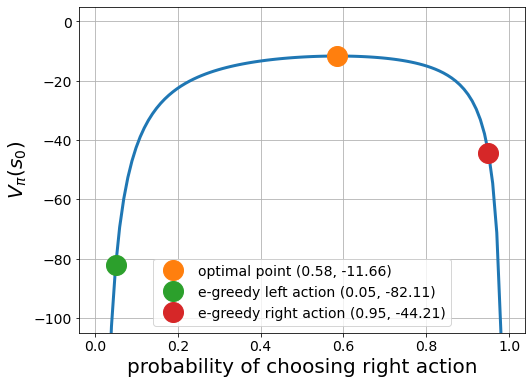

In [4]:
p=np.linspace(0.01, 0.99, 100)
v=v0(p)

op_p = np.argmax(v)
p_op = p[op_p]
v_op = v[op_p]

plt.rcParams['font.size']='14'
plt.figure(figsize=(8,6))
plt.plot(p,v,linewidth=3)
plt.plot(p_op,v_op,'o',markersize=20,label="optimal point ({0:.2f}, {1:.2f})".format(p_op, v_op))
plt.ylim(ymin=-105.0, ymax=5)

epsilon = 0.05

plt.plot(epsilon, v0(epsilon), 'o',markersize=20,
         label="e-greedy left action ({0:.2f}, {1:.2f})".format(epsilon, v0(epsilon)))
plt.plot(1-epsilon, v0(1-epsilon), 'o',markersize=20,
         label="e-greedy right action ({0:.2f}, {1:.2f})".format(1-epsilon, v0(1-epsilon)))
plt.legend()
plt.grid()
plt.ylabel('$V_{\pi}(s_0)$',fontsize=20)
plt.xlabel('probability of choosing right action',fontsize=20)
plt.savefig('egreedy_shortcorridor.png',dpi=350)

### reinforce

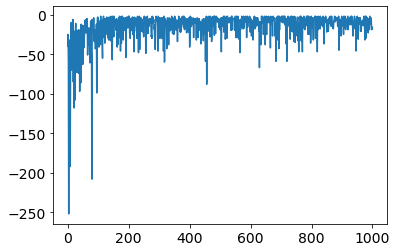

In [39]:
def policy(theta,phi):
    h=np.dot(theta,phi)
    upper=np.exp(h-np.max(h)) #avoid overflow
    pi=upper/np.sum(upper)
    
    #keep stochasitc policy with a_min>=0.05
    a_min=np.argmin(pi)
    epsilon=0.05
    if pi[a_min]<epsilon:
        pi[:]=1-epsilon
        pi[a_min]=epsilon
        
    if np.random.uniform()<=pi[0]:
        a=0
    else:
        a=1
        
    return a,pi

#calculate derivative of log policy
def dlog(phi,a,pi):
    
    return phi[:,a]-np.dot(phi,pi)

#get discounted return
def get_return(rewards,gm):
    
    R=np.zeros(len(rewards))
    R[-1]=rewards[-1]
    for i in range(2,len(R)+1):
        R[-i]=gm*R[-i+1]+rewards[-i]
        
    return R
    
def run_reinforce(lr=2e-4, gm=1, n_eps=1000):
    
    theta=np.array([-1.47,1.47])
    phi=np.array([[0,1],[1,0]])
    
    s_all,r_all,pi_all=[],[],[]
    
    for ep in range(n_eps):
        s,stp,r_sum,done=0,0,0,False
        actions,rewards,policies=[],[],[]

        while not done:
            a,pi=policy(theta,phi)
            pi_all.append(pi)
            s_,r,done=step(s,a)

            actions.append(a)
            rewards.append(r)
            policies.append(pi)

            s=s_
            stp+=1
        
        R=get_return(rewards,gm)
        
        #update policy parameters
        gmt=1
        for i in range(len(rewards)):
            theta+=lr*gmt*R[i]*dlog(phi,actions[i],policies[i])
            gmt*=gm

        r_all.append(sum(rewards))
        s_all.append(stp)
        #print(f'ep:{ep}, ret:{r_sum}')
        
    return r_all,s_all,pi_all

r,s,pi=run_reinforce()
plt.plot(r)
n_runs=100


from collections import defaultdict
r_res=defaultdict(list)
lr_all=[2e-4,2e-5,2e-3]

for lr in lr_all:
    for n in range(n_runs):
        r,s,pi=run_reinforce(lr=lr)
        r_res[str(lr)].append(r)    


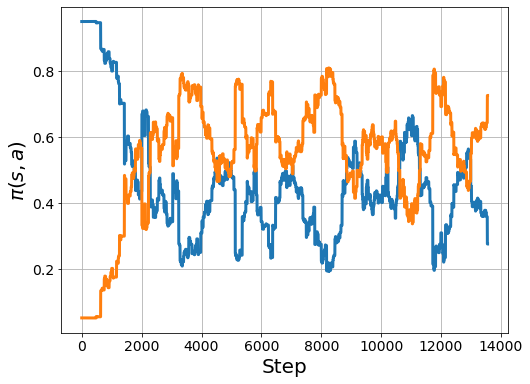

In [40]:
plt.figure(figsize=(8,6))
plt.plot(pi,linewidth=3)
plt.grid()
plt.xlabel('Step',fontsize=20)
plt.ylabel('$\pi(s,a)$',fontsize=20)
plt.savefig('reinforce_pi_shortcorridor.png',dpi=350)

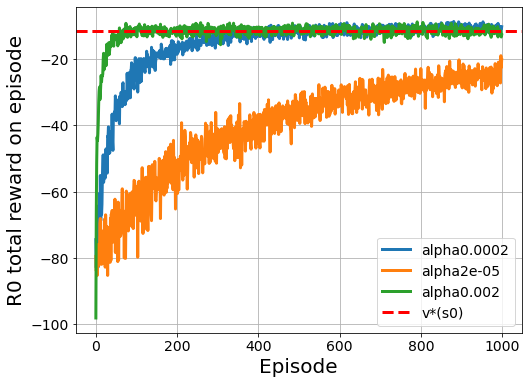

In [41]:
#plt.rcParams['font.size']='14'
plt.figure(figsize=(8,6))
for k,v in r_res.items():
    plt.plot(np.array(v).mean(axis=0),label='alpha'+k,linewidth=3)
    
plt.grid()
plt.axhline(y=-11.6, color='r', linestyle='--',linewidth=3,label='v*(s0)')
plt.legend()
plt.xlabel('Episode',fontsize=20)
plt.ylabel('R0 total reward on episode',fontsize=20)
plt.savefig('reinforce_shortcorridor.png',dpi=350)